# Needed Libraries

In [ ]:
%%capture
# General
import os
os.system("pip install wget")
import wget
import zipfile
import json
import re
import shutil
import math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Dict, Union, Set, Iterable, Tuple, Any
from tqdm.auto import tqdm
import pandas as pd
import time
from datetime import datetime

# For Scraping
from bs4.element import Tag
from bs4 import BeautifulSoup
from urllib.error import HTTPError
from urllib.request import urlopen

# For Search Engine
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from joblib import dump, load
from sortedcontainers import SortedSet, SortedList
from collections import Counter

import heapq

# Mapping
import plotly.express as px
import ast

# 1. Data Collection

## Getting all `placeURL` and save them to a file.txt

In [ ]:
def which_urls(n: int = 400,
               start: int = 0) -> List[str]:
  """This function returns a list containing all the desired "https://www.atlasobscura.com/places?page={i}&sort=likes_count" urls,
  where {i} is a number between 1 and n.

  Args:
    - n (int): The number of total pages to request. Defaul 400.
    - start (int): Starting point: Default 0.

  Returns:
    - List[str]: A list containg all the possible urls.
  """
  return [f"https://www.atlasobscura.com/places?page={i+1}&sort=likes_count" for i in range(start, n)]



def save_urls(path: str = "urls.txt",
              n: int = 400,
              start: int = 0,
              t: int = 3) -> None:
  """It saves all the urls in a txt file.

  Args
    - path (str): The path where to save the txt file. Deafult pages.
    - n (int): The number of pages to download. Default 400.
    - start (int): Starting point. Default 0.
    - t (int): Time to wait in min. Default 3.

  Returns:
    - None
  """
  path = Path(path)

  if start == 0:
    with open(path, 'w') as f:
      f.write("placeURL")

  while True:
    try:
      for i, url in enumerate(tqdm(which_urls(n, start))):
        start = i
        page = urlopen(url)
        html = page.read().decode("utf-8")
        soup = BeautifulSoup(html, "html.parser")

        urls = ["https://www.atlasobscura.com"+url['href'] for url in soup.find_all("a", {"class": "content-card-place"}, href=True)]

        with open(path, 'a') as f:
          for link in urls:
            f.write('\n'+link)
      return None

    except HTTPError as e:
      if e.code == 429:
        print(f"At iter {start} we've got a {e}", end="\t")
        time.sleep(60*t)
        print(f"[waited {t} min]\n\nContinue...")

We use our custom function `save_urls()`, which opens each of the initial 400 pages, it scrapes them in seach of the urls and then saves the results in `urls.txt`.

We have uploaded the .txt file to a personal S3 bucket. In this way we can retrieve it every time we need it.

## Retrieve the html for each place

In [ ]:
def download_zip(url: str) -> None:
  """A function that we'll use to download our files saved on our S3.
  The function works with any type of url.

  Args:
    - url (str): The url where the file is saved.

  Return:
    - None
  """
  print(f"Start download from {url}...", end="\t")
  try:
    filename = wget.download(url)
  except Exception as e:
    print("[FAILED]")
    print(e)
  else:
    print("[DONE]")
    print(f"File saved in /content/{filename}")

    if filename.split(".")[-1] == "zip":
      with zipfile.ZipFile(filename, "r") as zip_ref:
        print(f"Unzipping {filename}...", end='\t')
        zip_ref.extractall()
        print("[DONE]")
        os.remove(f"/content/{filename}")

In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/urls.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/urls.zip...	[DONE]
File saved in /content/urls.zip
Unzipping urls.zip...	[DONE]


In [ ]:
def get_htmls(urls_file: str = "urls.txt",
              path: str = "pages",
              start: int = 0,
              t : int = 3) -> None:
  """This function saves the html pages of each url saved in the file.txt stored at urls_file.

  Args:
    - urls_file (str): Where the file.txt is stored. Default urls.txt.
    - path (str): Where to save the html files. Default pages.
    - start (int): Starting point. Default 0.
    - t (int): Time to wait in min. Default 3.

  Returns:
    - None
  """
  path = Path(path)

  if not path.is_dir():
    os.mkdir(path)

  while True:
    try:
      for url in tqdm(pd.read_csv(urls_file)['placeURL'][start:]):
        start = len(list(path.glob("*")))
        page = urlopen(url)
        html = page.read().decode("utf-8")

        os.mkdir(path/Path(f"page {start+1}"))
        with open(path/Path(f"page {start+1}")/Path("html"), "w") as file:
          file.write(html)

      return None
    except HTTPError as e:
      if e.code == 429:
        print(f"At iter {start} we've got a {e}", end="\t")
        time.sleep(60*t)
        print(f"[waited {t} min]\n\nContinue...")

We use our custom function `get_htmls()` to get and to save the html file for each place in a directory with the following structure:



```
pages
|_ page 1
|  |_ html
|
|_ page 2
|  |_ html
|
...
|_ page 7200
   |_ html
```

We can then zip it and finally we can upload the .zip file to a S3 bucket. In this way we can retrieve all the html files when we need without sending requests to the site.







## Scraping

In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/pages.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/pages.zip...	[DONE]
File saved in /content/pages.zip
Unzipping pages.zip...	[DONE]


In [ ]:
def my_find(soup: Tag,
            what: str,
            typology: Dict[str, str] = {},
            script: str = "",
            separator: str = "") -> str:
  """A version of the find() function that handles the NoneType problem.

  Args:
    - soup (bs4.element.Tag): The bs4.element.Tag object.
    - what (str): The html tag we are looking for.
    - typology (Dict[str, str]): The specific class or id of the searched tag. Default {}.
    - script (str): If the tag is a scrip this parameter should be set for the type. Deafult "".
    - separator (str): The separator for the get_text() method. Default "".
  
  Returns:
    - str : The result of the search in str format.
  """
  if what == 'script':
    finded = soup.find(what, type=script)
    if finded is not None:
      return finded.text
    else:
      return ""
  else:
    finded = soup.find(what, typology)
    if finded is not None:
      return finded.get_text(separator=separator)
    else:
      return ""

def my_find_all(soup: Tag,
                what: str,
                typology: Dict[str, str] = {},
                separator: str = "") -> List[str]:
  """A version of the find_all() function that handles the NoneType problem.

  Args:
    - soup (bs4.element.Tag): The bs4.element.Tag object.
    - what (str): The html tag we are looking for.
    - typology (Dict[str, str]): The specific class or id of the searched tag. Default {}.
    - separator (str): The separator for the get_text() method. Default "".
  
  Returns:
    - List[str] : The results of the search in List[str] format.
  """
  finded = soup.find_all(what, typology)

  if len(finded) == 0:
    return [""]
  else:
    return [elem.get_text(separator=separator) for elem in finded]

def find_locations(soup: Tag,
                   category: str) -> Union[List[List[str]], List[str]]:
  """This function find inside a bs4.element.Tag object all the locations of a specific category.

  Args:
    - soup (bs4.element.Tag): A bs4.element.Tag object.
    - category (str): The specific category.

  Returns:
    - List[List[str]] : The List containing a List of all the locations of that specific category.
  """
  for elem in soup.find_all("div", {"class": "CardRecircSection"}):
    if my_find(elem, "div", {"class": "CardRecircSection__title"}).strip().split(" ")[0] == category:
      return [[location.strip() for location in my_find_all(elem, "h3", {"class": "Card__heading"})]]
  return [""]

def scrape(path: str = "pages",
           save_path: str = "places",
           start: int = 0) -> None:
  """A function that scrapes the html pages we have stored previously.

  Args:
    - path (str): The path to the html files. Default pages.
    - save_path (str): The path where to save the csv files. Default places.
    - start (int): The starting point. Default 0.

  Returns:
    - None
  """
  path = Path(path)
  save_path = Path(save_path)

  if save_path.is_dir():
    shutil.rmtree(save_path, ignore_errors=True)  
  
  os.mkdir(save_path)

  for i, html_path in enumerate(tqdm(sorted(list(map(str, path.glob("*/html"))), key=lambda x: int(x.split("/")[1].split(" ")[1]))[start:])):
    
    with open(html_path, 'r') as html:

      soup = BeautifulSoup(html, "html.parser")

      df = pd.DataFrame()

      df["placeName"] = [my_find(soup, "h1", {"class": "DDPage__header-title"}).strip()]
      df["placeTags"] = [my_find(soup, "div", {"class": "DDPage__header-place-location"}).split(", ") if my_find(soup, "div", {"class": "DDPage__header-place-location"}) else ""]
      df["numPeopleVisited"] = int([visitors for visitors in my_find_all(soup, "div", {"class": "item-action-count"})][0]) # da aggiustare
      df["numPeopleWant"] = int([visitors for visitors in my_find_all(soup, "div", {"class": "item-action-count"})][1]) # da aggiustare
      df["placeDesc"] = my_find(soup, "div", {"id": "place-body"}).strip().replace("\n", " ")
      df["placeShortDesc"] = [my_find(soup, "h3", {"class": "DDPage__header-dek"}).strip()]
      df["placeNearby"] = find_locations(soup, "Near")
      df["placeAddress"] = [address.replace("\n", "") for address in my_find_all(soup, "address", {"class": "DDPageSiderail__address"}, separator=" ")]
      coordinates = my_find(soup, "div", {"class": "DDPageSiderail__coordinates"}).split(", ")
      df["placeAlt"] = float(coordinates[0].strip())
      df["placeLong"] = float(coordinates[1].strip())
      df["placeEditors"] = [[re.sub('[a-z]*[A-Z]*[\n]+', '', editor.strip()) for editor in my_find_all(soup, "a", {"class": "DDPContributorsList__contributor"})]]
      df["placePubDate"] = [datetime.strptime(my_find(soup, "div", {"class": "DDPContributor__name"}), "%B %d, %Y") if my_find(soup, "div", {"class": "DDPContributor__name"}) != "" else ""]
      df["placeRelatedLists"] = find_locations(soup, "Appears")
      df["placeRelatedPlaces"] = find_locations(soup, "Related")
      df["placeURL"] = [json.loads(my_find(soup, 'script', script='application/ld+json'), strict=False)['url']]

      df.to_csv(save_path/Path(f"place_{i+1}.tsv"), sep="\t", index=False)

We run the function `scrape()` to scrape all the html files and save the results in .tsv files that we store in a folder.

```
places
|_ place_1.tsv
|
|_ place_2.tsv
|
...
|_ place_7200.tsv
```


We can now zip it and then manually upload it on our S3 bucket, in this way we don't have to recompute the result.



# 2. Search Engine

## Download all the data we need

In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/places.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/places.zip...	[DONE]
File saved in /content/places.zip
Unzipping places.zip...	[DONE]


In [ ]:
def create_total_dataframe(path: str = "places") -> None:
  """This function creates a total version of the data, indexed on the file.tsv name and stores it in a data.csv file.

  Args:
    - path (str): The path to the data.

  Returns:
    - None
  """
  path = Path(path)

  df = pd.DataFrame()

  for tsv in tqdm(sorted(list(map(str, path.glob("*.tsv"))), key=lambda x: int(x.split("/")[1].split("_")[1].split(".")[0]))):
    place_df = pd.read_csv(tsv, delimiter="\t")
    place_df["placeFile"] = tsv.split("/")[1].split(".")[0]
    df = pd.concat([df, place_df.set_index(["placeFile"])])

  df.to_csv("data.csv", sep=",")
  return None

In [ ]:
create_total_dataframe()

  0%|          | 0/7200 [00:00<?, ?it/s]

We had also saved the `data.csv` file on our S3 Bucket ([data.zip](https://datasciencemep27.s3.amazonaws.com/data.zip)).

## Visualize the data

Using `data.csv` we can look at some statistics of our dataset.

We use `ast.literal_eval()` method to transform the string version of the lists in list. 

In [ ]:
df = pd.read_csv("data.csv", index_col="placeFile", dtype={'INDEX':str})

df["placeTags"] = df["placeTags"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df["placeNearby"] = df["placeNearby"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df["placeEditors"] = df["placeEditors"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df["placeRelatedLists"] = df["placeRelatedLists"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df["placeRelatedPlaces"] = df["placeRelatedPlaces"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)

We have found that [Atlas Obscura](https://www.atlasobscura.com/) ranks the **Most Popular Places** by the value of `numPeopleWant`:


In [ ]:
display(df)

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL
placeFile,,,,,,,,,,,,,,,
place_1,City Hall Station,"[Manhattan, New York]",1826,8572,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"[African Burial Ground National Monument, Tunn...","31 Centre St New York, New York, 10007 U...",40.7134,-74.0046,"[Rebekah Otto, Habicurious, charding407, Annet...",2010-05-08,[30 Unexpected Places to Have a Joyful Adventu...,"[Crystal Palace Subway, Moscow Metro Stations,...",https://www.atlasobscura.com/places/city-hall-...
place_2,Highgate Cemetery,"[London, England]",2616,8180,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"[World's Largest Potted Plant, Dick Whittingto...","Swain's Lane, Highgate London, England, ...",51.5675,-0.1483,"[Goksu, Rob, SEANETTA, anthonyhogg, Monsieur M...",2014-08-09,"[The World's Top 100 Wonders in 2018, London's...","[Jewett City Vampires, Tomb of the Mather Fami...",https://www.atlasobscura.com/places/highgate-c...
place_3,Leadenhall Market,"[London, England]",3133,7561,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"[The Cornhill Devils, London's Original and Al...","London, England, EC3V United Kingdom",51.5126,-0.0834,"[Meg, MagnumPI, JulesR, caraobrien, JZA, honey...",2016-08-01,"[The Ultimate Guide to Stunning, Surprising, o...","[Rivendell, Bagdad Cafe, Gare de la Ciotat, Dr...",https://www.atlasobscura.com/places/leadenhall...
place_4,The Wave Organ,"[San Francisco, California]",2427,7401,"Located on a jetty in the San Francisco Bay, t...",A huge musical instrument played by the ocean.,"[Long Now Orrery, The Stern of the Brigantine ...","83 Marina Green Dr San Francisco, Califo...",37.8085,-122.4401,"[mbison, td007, bylow1md, hana, routt1111, cat...",2008-11-21,[Leonardo Nam's 16 Quirky Roadside Attractions...,"[Sea Organ, Silent Green Kulturquartier, St. J...",https://www.atlasobscura.com/places/wave-organ
place_5,Catacombes de Paris,"[Paris, France]",4443,7037,"In 2004, Parisian police were assigned to do a...","The vast, legendary catacombs hold secrets muc...","[Sculptures de Décure, Arago Medallions, Jeann...","1 Place Denfert-Rochereau Paris, 75014 F...",48.8343,2.3322,"[CPilgrim, gingercinnamon, keith, TeaAndCoffee...",2009-02-13,"[19 Catacombs Sure to Tingle Your Spine, The W...","[Ossario di San Martino, Leuk Charnel House, S...",https://www.atlasobscura.com/places/catacombes...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
place_7196,The Cairo,"[Washington, D.C.]",342,405,Washington D.C.’s residential neighborhoods ar...,This unacceptably tall building was the real r...,"[Annie's Paramount Steakhouse, Charlotte Forte...","1615 Q Street NW Washington, District of...",38.9113,-77.0375,"[Elliot Carter, matthewbgilmore, Greg Jones]",2017-09-12,NaN,"[145 Rue Lafayette, Architect of the Capitol A...",https://www.atlasobscura.com/places/the-cairo-...
place_7197,Winganon Space Capsule,"[Talala, Oklahoma]",120,405,Any out of town-ers driving along the dull str...,A detached cement mixer has been transformed t...,"[Bowling Ball Yard Art, Totem Pole Park, Playt...","E 300 Road Talala, Oklahoma United States",36.5828,-95.6516,"[nervisgun, Zain Ahmed, CoolCrab, MNtraveler, ...",2017-08-14,NaN,"[Folk Art Park, Apple Valley Hillbilly Garden ...",https://www.atlasobscura.com/places/winganon-s...
place_7198,Cook & Book,"[Brussels, Belgium]",124,405,Cook & Book in Brussels is far more than just ...,A wonderfully kitsch bookstore the size of a s...,"[Bibliotheca Wittockiana, Temple of Human Pass...",1 Place du Temps Libre Woluwe-Saint-Lamb...,50.8480,4.4373,"[Producer Dani, simonlitton, rhumphrey17]",2017-02-08,[The Ultimate Guide to Wondrous Independent Bo...,"[For Keeps Bookstore, Fantagraphics

So the highest value for `numPeopleWant` is going to be the place at line 0, and the lowest is going to be the element at line 7199... but if we search for the minimum value of `numPeopleWant` we find out that there is a place (at line 6041) that has a value of 2.

In [ ]:
pd.DataFrame(df.loc[df.numPeopleWant.idxmin()])

,place_6042
placeName,Shangri La Botanical Gardens & Nature Center
placeTags,NaN
numPeopleVisited,0
numPeopleWant,2
placeDesc,“…I determined to gather together all things o...
placeShortDesc,Cradled in the midst of a southeast Texas town...
placeNearby,NaN
placeAddress,"2111 W. Park Ave., Orange, TX 77630"
placeAlt,0.0
placeLong,0.0


This is strage, but going on the website it is possible to see that this place indeed appears really hight in the list, so we think it is a problem of [Atlas Obscura](https://www.atlasobscura.com/) website.

![](https://datasciencemep27.s3.amazonaws.com/atlas-obscura.png)

We can notice that we don't have NaN values for `placeDesc` and `placeShortDesc`, these two columns are really important for building our Search Engine, so it's essential that they are not NaN.

placeName                0
placeTags                1
numPeopleVisited         0
numPeopleWant            0
placeDesc                0
placeShortDesc           0
placeNearby              1
placeAddress             0
placeAlt                 0
placeLong                0
placeEditors             0
placePubDate             1
placeRelatedLists     4440
placeRelatedPlaces      34
placeURL                 0
dtype: int64

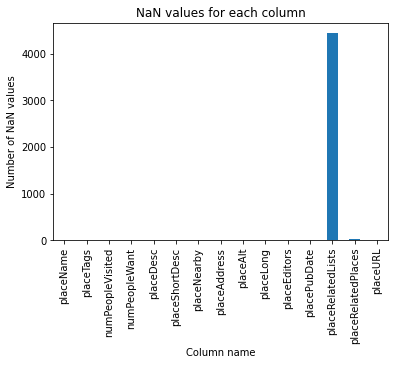

In [ ]:
display(df.isnull().sum())
df.isnull().sum().plot(kind="bar", title="NaN values for each column", ylabel="Number of NaN values", xlabel="Column name");

## Preprocessing the data

We set the strings in `placeName`, `placeDesc` and `placeShortDesc` to lower case.

In [ ]:
reduced_df = df[["placeDesc"]].copy()

reduced_df["placeDesc"] = reduced_df["placeDesc"].astype(str).str.lower()

In [ ]:
display(reduced_df.head())

,placeDesc
placeFile,
place_1,the first new york city subway was built and o...
place_2,"opened in 1839, highgate is one of london’s mo..."
place_3,the ornate 19th-century painted roof and cobbl...
place_4,"located on a jetty in the san francisco bay, t..."
place_5,"in 2004, parisian police were assigned to do a..."


We tokenize each field, in this way we remove punctuation.

In [ ]:
regexp = RegexpTokenizer('\w+')

reduced_df['placeDesc'] = reduced_df['placeDesc'].apply(regexp.tokenize)

In [ ]:
display(reduced_df.head())

,placeDesc
placeFile,
place_1,"[the, first, new, york, city, subway, was, bui..."
place_2,"[opened, in, 1839, highgate, is, one, of, lond..."
place_3,"[the, ornate, 19th, century, painted, roof, an..."
place_4,"[located, on, a, jetty, in, the, san, francisc..."
place_5,"[in, 2004, parisian, police, were, assigned, t..."


We remove the stopwords:

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")

reduced_df['placeDesc'] = reduced_df['placeDesc'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
display(reduced_df.head())

,placeDesc
placeFile,
place_1,"[first, new, york, city, subway, built, operat..."
place_2,"[opened, 1839, highgate, one, london, infamous..."
place_3,"[ornate, 19th, century, painted, roof, cobbled..."
place_4,"[located, jetty, san, francisco, bay, wave, or..."
place_5,"[2004, parisian, police, assigned, training, e..."


We perform the stemming step using `PorterStemmer`:

In [ ]:
porter_stemmer = PorterStemmer()

reduced_df['placeDesc'] = reduced_df['placeDesc'].apply(lambda x: [porter_stemmer.stem(item) for item in x])

In [ ]:
display(reduced_df.head())

,placeDesc
placeFile,
place_1,"[first, new, york, citi, subway, built, oper, ..."
place_2,"[open, 1839, highgat, one, london, infam, ceme..."
place_3,"[ornat, 19th, centuri, paint, roof, cobbl, flo..."
place_4,"[locat, jetti, san, francisco, bay, wave, orga..."
place_5,"[2004, parisian, polic, assign, train, exercis..."


We keep only words which are longer than 2 letters:

In [ ]:
reduced_df['placeDesc'] = reduced_df['placeDesc'].apply(lambda x: [item for item in x if len(item)>2])

In [ ]:
display(reduced_df.head())

,placeDesc
placeFile,
place_1,"[first, new, york, citi, subway, built, oper, ..."
place_2,"[open, 1839, highgat, one, london, infam, ceme..."
place_3,"[ornat, 19th, centuri, paint, roof, cobbl, flo..."
place_4,"[locat, jetti, san, francisco, bay, wave, orga..."
place_5,"[2004, parisian, polic, assign, train, exercis..."


## 2.1 Create the Vocabulary

In [ ]:
class Vocabulary():
  """A vocabulary of words present in pd.DataFrame columns.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame from which to build the vocabulary.
    - columns (List[str]): Which columns of the pd.DataFrame to use, if None all columns are used. Default None.

  Attributes:
    - dataframe (pd.Dataframe): Where it is stored the dataframe input.
    - columns (List[str]): Where it is stored the columns input.
    - index2word (Dict[str, str]): A dictionary in which we have as keys the index and as values the words.
    - word2index (Dict[str, str]): A dictionary in which we have as keys the word and as values the corresponding numbers in the index2word index.
    - word2frequency (Dict[str, int]): A dictionary in which we have as keys words and as values the numbers of occurences of that word in the entire corpus.
    - num_words (int): Number of total words in the vocabulary.
    - maximum_frequency (int): The maximum frequency.
    - words_with_maxf (List[str]): The list of words with the maximum frequency.
  """
  def __init__(self,
               dataframe: pd.DataFrame,
               columns: List[str] = None):

    self.index2word = {}
    self.word2index = {}
    self.word2frequency = {}
    self.num_words = 0
    self.maximum_frequency = 0
    self.words_with_maxf = []

    self.columns = columns

    if self.columns is None:
      self.columns = list(dataframe.columns)
    
    self.dataframe = dataframe[self.columns]

    for column in tqdm(self.columns):
      for elem in self.dataframe[column]:
        for word in elem:
          self.add_word(word)

  def __getitem__(self,
                  item: Union[int, str]) -> Union[str, int]:
      """Override of the __getitem__ method:
      Given an int as index, it returns the word corresponding to that index.
      Given a str as word, it returns the index corresponding to that word.

      You could also use 'get_word(index)' method if your searching for a word given an index.
      You could also use 'get_index(word)' method if your searching for an index given a word.

      Args:
        - item (int / str): If int it is index of the word, if str it is the word.

      Returns:
        - str / int : if item is int, then it returns the corresponding word, while if item is str it returns the corresponding index for that word.
      """
      if isinstance(item, int):
        return self.index2word[item]
      elif isinstance(item, str):
        return self.word2index[item]
      else:
        raise Exception("Item is expected to be an integer if you're searching the corresponding word, or a str if you're searching the index")

  def __str__(self):
    """An override of the '__str__()' method, in this way we're able to print some informations about the vocabulary.

    Returns:
      - str : The str rappresentation of the vocabulary.
    """
    return f"Number of words in the vocabulary: {self.num_words}\nMaximum frequency value: {self.maximum_frequency} -> List of words with the maximum frequency: {self.words_with_maxf}"

  def __len__(self) -> int:
    """An ovverride of the '__len__()' method:

    Returns:
      - self.num_words (int): The number of words present in the Vocabulary.
    """
    return self.num_words

  def add_word(self,
               word: str) -> None:
    """A function used to add a word to our vocabulary.

    Args:
      - word (str): The word to add.
    
    Returns:
      - None
    """
    if word not in self.word2index:
      self.word2index[word] = self.num_words
      self.word2frequency[word] = 1
      self.index2word[self.num_words] = word
      self.num_words += 1

      if self.word2frequency[word] > self.maximum_frequency:
        self.maximum_frequency = self.word2frequency[word]
        self.words_with_maxf = [word]
      elif self.word2frequency[word] == self.maximum_frequency:
        self.words_with_maxf.append([word])

    else:

      self.word2frequency[word] += 1

      if self.word2frequency[word] > self.maximum_frequency:
        self.maximum_frequency = self.word2frequency[word]
        self.words_with_maxf = [word]
      elif self.word2frequency[word] == self.maximum_frequency:
        self.words_with_maxf.append(word)

    return None

  def get_word(self,
               index: int) -> str:
      """Given an int as index, it returns the word corresponding to that index.
      You could also use 'Vocabulary[index]'.

      Args:
        - index (int): The index of the word.

      Returns:
        - str : The word corresponding to that index.
      """
      return self.index2word[index]

  def get_index(self,
                word: str) -> int:
      """Given a str as a word, it returns the index corresponding to that word.
      You could also use 'Vocabulary[word]'.

      Args:
        - word (word): The word.

      Returns:
        - int : The index corresponding to that word.
      """
      return self.word2index[word]

  def get_frequency(self,
                    word: str) -> int:
    """It returns the corresponding frequency of the input word.

    Args:
      - word (str): A word in the vocabulary.

    Returns:
      - int : The corresponding frequency.
    """
    return self.word2frequency[word]
  
  def words(self):
    """Get the list of words present in the vocabulary.

    Returns:
      - List[str] : The list of all the words.
    """
    return list(self.word2index.keys())
  
  def sort_fun(self,
               x: str) -> int:
    """A function used to sort the SortedSet on the created index.

    Args:
      - x (str): The document.

    Returns:
      - int : The number code of that document.
    """
    return int(x.split("_")[1])

  def create_index(self,
                   path: str = None) -> Dict[int, SortedSet]:
    """A function that returns the index on the corpora of the self.dataframe using the vocabulary.

    Args:
      - path (str): The name of the pickle file where we save the index, if None the index is not saved. Default None.

    Returns:
      - index (Dict[int, SortedSet]): The index of the self.dataframe based on the vocabulary.
    """
    index = {}

    for word in tqdm(self.words()):
      index[self.word2index[word]] = SortedSet(key=self.sort_fun)
      for column in self.columns:
        index[self.word2index[word]].update(self.dataframe.index[self.dataframe[column].apply(lambda x: word in x)].tolist())

    if path:
      dump(index, path)

    return index

  def save(self,
           path: str) -> None:
    """Save the vocabulary as a pickle file.

    Args:
      - path (str): The name/path where to save the vocabulary.

    Returns:
      - None
    """
    dump(self, path)
    return None

  @classmethod
  def loader(self,
             path: str):
    """Load the vocabulary from a pickle file.

    Args:
      - path (str): The path to the picke file.
    """
    return load(path)

In [ ]:
voc = Vocabulary(reduced_df)

  0%|          | 0/1 [00:00<?, ?it/s]

We can print some info about the vocabulary:

In [ ]:
print(voc)

Number of words in the vocabulary: 39837
Maximum frequency value: 6996 -> List of words with the maximum frequency: ['one']


Using the method `save()` of the `Vocabulary` class, we can save the vocabulary:


```python
voc.save("voc.pkl")
```

Then we can retrieve it by using the `loader()` method:


```python
loaded_voc = Vocabulary.load("voc.pkl")
```

We had downloaded the `voc.pickle` as a .zip file and stored it in the same S3 Bucket ([voc.zip](https://datasciencemep27.s3.amazonaws.com/voc.zip)).



### 2.1.1 Creating the index:

In [ ]:
class Index():
  """An Index that has as keys words and as corresponding values SortedSets of the documents where each word is contained.

  Args:
    - index (Dict[int, Iterable[str]]): The dictionary to index.

  Attributes:
    - index (Dict[int, Iterable[str]]): A dictionary that has as key the term_id and as value the SortedSet of documents that contains that word. Default None.
    - num_words (int): The number of words in the index.
  """
  def __init__(self,
               index: Dict[int, Iterable[str]] = None):
    self.index = {}
    self.num_words = 0

    if index is not None:
      for term_id in tqdm(list(index.keys())):
        self.index[term_id] = SortedSet(index[term_id], key=self.sort_fun)
        self.num_words += 1

  def __setitem__(self,
                  term_id: int,
                  documents: SortedSet) -> None:
    """An override of the method __setitem__.

    Args:
      - word (str): The term_id to add in our dictionary.
      - documents (SortedSet): The SortedSet of documents in which word is present.
    """
    if not isinstance(term_id, int):
      raise Exception(f"The items in the index should be an int, got a: {type(term_id)}")
    if not isinstance(documents, SortedSet):
      raise Exception(f"The value for each item should be a SortedSet, got a: {type(documents)}")

    self.index[term_id] = documents
    self.num_words += 1

    return None

  def __getitem__(self,
                  term_id: int) -> SortedSet:
    """Override of the __getitem__ method:
    Given an int as term_id, it returns the index corresponding documents in which the term is present.

    Args:
      - term_id (int): The term_id of the word to search for.

    Returns:
      - SortedSet:  It returns the documents in which that word is present.
    """
    if not isinstance(term_id, int):
      raise Exception("Item is expected to be an int.")

    try:
      result = self.index[term_id]
    except:
      print(f"'{term_id}' not found in Index")
      result = SortedSet()

    return result

  def __str__(self) -> str:
    """An override of the '__str__()' method:

    Returns:
      - str : A string view of the Index.
    """
    return f"{self.index}"

  def __len__(self) -> int:
    """An override of the __len__ method.

    Returns
      - self.num_words (int): The number of words present in the Index.
    """
    return self.num_words
  
  @classmethod
  def sort_fun(self,
               x: str) -> int:
    return int(x.split("_")[1])

  def keys(self) -> List[int]:
    """Get the list of words present in the index.

    Returns:
      - List[int] : The list of all the words term_id.
    """
    return list(self.index.keys())

  def save(self,
           path: str) -> None:
    """To save an Index in a given path.

    Args:
      - path (str): The path where the index is going to be saved.

    Returns:
      - None
    """
    dump(self, path)
    return None
  
  @classmethod
  def loader(self,
             path: str) -> None:
    """The loader method used to load a saved Index.

    Args:
      - path (str): The path where the index to load is stored.

    Returns:
      - None
    """
    index = load(path)

    if not isinstance(index, Index):
      index = Index(index)

    return index

We can use the method `create_index()` defined in the `Vocabulary` class:


```python
index = Index(voc.create_index("index.pkl"))
```

The ouput is an index with the following structure:

```
{
term_id_1:[place_1, place_2, place_4],
term_id_2:[place_1, place_3, place_5, place_6],
...}
```

We pass as input a string with the name of the file where we're going to store the index, so that we can zip it and upload it to our S3 Bucket.



In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/index.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/index.zip...	[DONE]
File saved in /content/index.zip
Unzipping index.zip...	[DONE]


In [ ]:
index = Index.loader("index.pkl")

  0%|          | 0/39837 [00:00<?, ?it/s]

### 2.1.2 Execute the query:

In [ ]:
class SearchEngine():
  """A class that rappresent a Search Engine, here we find all the methods needed to query on the dataframe.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame to query.
    - vocabulary (Vocabulary): The vocabulary of the dataframe.
    - index: The index word->documents of the dataframe.

  Attributes:
    - dataframe (pd.DataFrame): The variable in which we save the dataframe input.
    - vocabulary (Vocabulary): The variable in which we save the vocabulary input.
    - index (Index): The variable in which we save the index input. 
  """
  def __init__(self,
               dataframe: pd.DataFrame,
               vocabulary: Vocabulary,
               index: Index):

    print("Sanity Check between the Vocabulary and the Index:", end="\t")
    if not len(vocabulary) == len(index) :
      raise Exception(f"Inconsistency between the number of words in the vocabulary and the number of words in the index.\nVocabulary: {len(vocabulary)}\nIndex: {len(index)}")

    print("[PASSED]")

    self.index = index
    self.dataframe = dataframe
    self.vocabulary = vocabulary

  def words(self) -> List[str]:
    """Returns the list of the words.

    Returns:
      - List[tr]: The list of the words.
    """
    return self.vocabulary.words()

  def tf(self,
         word: str,
         document: str) -> float:
    """The function that calculates TF of a word and a document.

    Args:
      - word (str): The word for which we calculate the TF.
      - document (str): The document for which we calculate the TF.

    Returns:
      - float : The TF value for that word and document.
    """
    frq_t_in_d = 0
    for column in self.vocabulary.dataframe.columns:
      frq_t_in_d += self.vocabulary.dataframe[column][document].count(word)

    return 1.0 + math.log10(frq_t_in_d)

  def idf(self,
          word: str) -> float:
    """The function that calculates IDF of a word and a document.

    Args:
      - word (str): The word for which we calculate the IDF.

    Returns:
      - float : The IDF value for that.
    """
    n_docs_with_word = (len(self.index[self.vocabulary.get_index(word)]))

    return math.log10((1.0+len(self.vocabulary.dataframe))/(1.0 + n_docs_with_word))+1.0

  def tf_idf(self,
             word: str,
             document: str) -> float:
    """The function that calculates TF-IDF of a word and a document.

    Args:
      - word (str): The word for which we calculate the TF-IDF.
      - document (str): The document for which we calculate the TF-IDF.

    Returns:
      - float : The TF value for that word and document.
    """
    return self.tf(word, document)*self.idf(word)

  def create_index_tf_idf(self,
                          path: str = None) -> Dict[int, List[Tuple[str, float]]]:
    """A function that returns the index tf-idf on the corpora of the self.dataframe.

    Args:
      - path (str): The name of the pickle file where we save the index, if None the index is not saved. Default None.

    Returns:
      - index_tf_idf (Dict[int, List[Tuple[str, float]]]): The index with the tf-idf.
    """
    self.index_tf_idf = {}
    for word in tqdm(self.words()):
      self.index_tf_idf[self.vocabulary.get_index(word)] = []
      for doc in self.index[self.vocabulary.get_index(word)]:
        self.index_tf_idf[self.vocabulary.get_index(word)].append((doc, self.tf_idf(word, doc)))

    if path:
      dump(self.index_tf_idf, path)

    return self.index_tf_idf

  def tf_idf_query(self,
                   query: List[str]) -> Dict[str, float]:
    """A function to calculate the TF-IDF for a query.

    Args:
      - query List[str]: A query.

    Returns
      - tf_idf_q (Dict[str, float]): The dictionary for the query with the TF-IDF value for each term.
    """
    tf_idf_q = {}
    
    for word in query:
      tf_idf_q[word] =(1.0+math.log10(query.count(word))) * self.idf(word)

    return tf_idf_q

  def cosine_similarity(self,
                         query: List[str],
                         document: str) -> float:
    """Cosine Similarity function.

    Args:
      - query List[str]: A query. 
      - document (str): A document.

    Returns:
      - float : The value of the cosine similarity between the query and the document.
    """
    tf_idf_q = self.tf_idf_query(query)

    q_vect = list(tf_idf_q.values())
    doc_vect = [self.index_tf_idf[self.vocabulary.get_index(word)][self.binary_search(self.index_tf_idf[self.vocabulary.get_index(word)], document)][1] for word in query]

    length_doc = np.linalg.norm(doc_vect)
    length_q = np.linalg.norm(q_vect)

    num = np.dot(doc_vect, q_vect)
    den = length_doc*length_q

    return num/den

  def binary_search(self,
                   alist: Iterable[Tuple[str, Any]],
                   document: str) -> int:
    """An custom version of the binary search method.

    Args:
      - alist (Iterable[Tuple[str, Any]]): An Iterable of the format ("document_d", "tf_idf_d_w").
      - document (str): The document id we're searching.

    Returns:
      - pos (int): The position of the document in the alist.
    """
    first = 0
    last = len(alist)-1
    found = False

    while first<=last and not found:
      pos = 0
      midpoint = (first + last)//2
      if alist[midpoint][0] == document:
          pos = midpoint
          found = True
      else:
          if int(document.split("_")[1]) < int(alist[midpoint][0].split("_")[1]):
              last = midpoint-1
          else:
              first = midpoint+1

    if not found:
      raise Exception(f"Document {document} not in word list.")

    return pos

  def load_tf_idf_index(self,
                        path: str) -> None:
    """The loader method used to load a saved Index.

    Args:
      - path (str): The path where the index to load is stored.

    Returns:
      - None
    """
    self.index_tf_idf = load(path)
    return None

  def clean_query(self,
                  query: str) -> List[str]:
    """We follow the same preprocessing steps we have done for the documents, but for the query.

    Args:
      -  query (str): The query.

    Returns:
      - List[str] : The cleaned version of the query.
    """
    query = query.lower()

    #We tokenize the query
    regexp = RegexpTokenizer('\w+')
    query = regexp.tokenize(query)

    # We remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    query = [item for item in query if item not in stopwords]

    # We execute stemming over the query
    porter_stemmer = PorterStemmer()
    query = [porter_stemmer.stem(item) for item in query]

    # Remove the words with less than 2 terms
    query = [item for item in query if len(item)>2]

    return query

  def query_index(self,
                  query) -> SortedSet:
    """A method to query the index.

    Args:
      - query (str): The Conjunctive query.

    Returns:
      - result_set (SortedSet): The result SortedSet of the query.
    """  
    for i, word in enumerate(query):
      if i == 0:
        result_set = self.index[self.vocabulary.get_index(word)]
      else:
        result_set = result_set.intersection(self.index[self.vocabulary.get_index(word)])

    return result_set

  def query_cosine_similarity(self,
                              query: str,
                              columns: List[str] = None,
                              k: int = None) -> List[Tuple[str, float]]:
    """Return the rows in the dataframe that answer to the query.

    Args:
      - query (str): The query to search for.
      - columns (List[str]): The dataframe columns to display, if none all of them. Default None.
      - k (int): Number of desired documents. Default None.

    Returns:
      - List[Tuple[int, str]] : A list of top-k documents with their ranking.
    """
    query = self.clean_query(query)

    if columns is None:
      columns = self.dataframe.columns

    copy = self.dataframe[columns].loc[self.query_index(query)].copy()
    copy["Similarity"] = copy.index.map(lambda x: self.cosine_similarity(query, str(x)))

    if k == None or k > len(copy):
      k = len(copy)

    sorted_copy = copy.sort_values(by="Similarity", ascending=False).head(k)

    display(sorted_copy)

    return [(i+1, doc) for i, doc in enumerate(sorted_copy.index)]

  def query(self,
            query: str,
            columns: List[str] = None) -> pd.DataFrame:
    """Return the rows in the dataframe that answer to the query.

    Args:
      - query (str): The query to search for.
      - columns (List[str]): The dataframe columns to display, if none all of them. Default None.

    Returns:
      - pd.DataFrame : The sub set of the dataframe that answers to the query.
    """
    query = self.clean_query(query)

    if columns is None:
      columns = self.dataframe.columns

    return self.dataframe[columns].loc[self.query_index(query)].sort_index(ascending=False)

In [ ]:
search_engine = SearchEngine(df, voc, index)

Sanity Check between the Vocabulary and the Index:	[PASSED]


Here are the result for the query `american museum`:

In [ ]:
display(search_engine.query("american museum", ["placeName", "placeDesc", "placeURL"]))

,placeName,placeDesc,placeURL
placeFile,,,
place_986,Horniman Museum and Gardens,London’s Horniman Museum has been showing off ...,https://www.atlasobscura.com/places/horniman-m...
place_971,Crazy Horse Memorial,When the carving of Mount Rushmore began in 19...,https://www.atlasobscura.com/places/crazy-hors...
place_955,Biosphere of Montreal,As their contribution to Montreal’s 1967 World...,https://www.atlasobscura.com/places/biosphere-...
place_913,Mothman Museum,Sitting in a storefront on an otherwise banal ...,https://www.atlasobscura.com/places/mothman-mu...
place_888,"Oak Ridge ""The Secret City""",The city of Oak Ridge was established by the U...,https://www.atlasobscura.com/places/the-secret...
...,...,...,...
place_1087,Albertine,A hand-painted ceiling of celestial scenes cap...,https://www.atlasobscura.com/places/albertine
place_1073,The Old Patent Model Museum,Before the Smithsonian reopened the building i...,https://www.atlasobscura.com/places/the-old-pa...
place_1051,Flushing Meadows-Corona Park,"After a long ride from Manhattan, most get off...",https://www.atlasobscura.com/places/flushing-m...


## 2.2 Conjunctive query & Ranking score

### What metrics we're going to use:

#### Term Frequency $\mathrm{tf}$:
Term frequency is usually defined as:

$$
\mathrm{tf}_{i,d} = \frac{n_{i,j}}{|d_j|}
$$

Where $n_{i,j}$ is the number of occurences of the term $i$ in the document $j$ and $|d_j|$ is the dimension (number of terms in the document) of the document $j$.

But we decided to implement $\mathrm{tf}_{i,d}$ using an other commonly used definition based on the following statement:

> *While it seems that more is better, a lot
isn’t proportionally better than a few...*

$$
\mathrm{tf}_{i,d} =
\begin{cases}
0.0 & \text{if the normal } n_{i,j}=0\\
1.0 + \log_{10}\left(n_{i,j}\right) & \text{else}
\end{cases}
$$

#### Inverse Document Frequency $\mathrm{idf}$
The inverse document frequency is defined as:

$$
\mathrm{idf}_{i} = 
\begin{cases}
0.0 & \text{if }|\{d\ :\ i\in d\}| = 0\\
\log_{10}\left(\frac{|D|}{|\{d\ :\ i\in d\}|}\right) & \text{else}
\end{cases}
$$

Where $|D|$ is the number of all the document we have in the corpora, and |$\{d\ :\ i\in d\}|$ is the number of document that contain the term $i$.

We have used set the [Sklearn's version](https://towardsdatascience.com/how-sklearns-tf-idf-is-different-from-the-standard-tf-idf-275fa582e73d):

$$
\mathrm{idf}_{i} = \log_{10}\left(\frac{1.0+|D|}{1.0+|\{d\ :\ i\in d\}|}\right) + 1.0
$$

### 2.2.1 Inverted Index

We can use the method `create_index_tf_idf()` defined in the `SearchEngine` class:


```python
index_tf_idf = search_engine.create_index_tf_idf("index_tf_idf.pkl")
```

The ouput is an index with the following structure:

```
{...
term_id_4:[(place_1, tfIdf_{term, place_1}), (place_2, tfIdf_{term, place_2})],
term_id_5:[(place_1, tfIdf_{term, place_1}), (place_3, tfIdf_{term, place_3}), (place_5, tfIdf_{term, place_5}))],
...}
```

We pass as input a string with the name of the file where we're going to store the index, so that we can zip it and upload it to our S3 Bucket.

In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/index_tf_idf.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/index_tf_idf.zip...	[DONE]
File saved in /content/index_tf_idf.zip
Unzipping index_tf_idf.zip...	[DONE]


We load the new index:

In [ ]:
search_engine.load_tf_idf_index("index_tf_idf.pkl")

We define an heap data structure for maintaining the top-k documents:

In [ ]:
class HeapDocs():
  """An heap data structure to mantain our Top K docs.

  Args:
    - data (List[Tuple[int, str]]): Our list of (ranking, doc_id).
  
  Attributes:
    - data (List[Tuple[int, str]]): The variable where we store the data input.
  """
  def __init__(self,
               data: List[Tuple[int, str]]):
    self.data = data
    heapq.heapify(data)

  def __len__(self) -> int:
    """An override of the '__len__()' method.

    Returns:
      - int : The length of our heap.
    """
    return len(self.data)

  def __str__(self) -> str:
    """An override of the '__str__()' method that is going to be used by print().

    Returns:
      - str : A string rappresentation of our heap
    """
    alist = [k for i, k in self.data]
    alist = '", "'.join(alist)
    return f'["{alist}"]'

  def pop(self) -> str:
    """Pop the biggest element from our heap.

    Returns:
      - str : The document id with the highest similarity score in the heap.
    """
    return heapq.heappop(self.data)[1]

  def top(self) -> str:
    """Return the biggest element from our heap.

    Returns
      - str : The document id with the highest similarity score in the heap.
    """
    return self.data[0][1]

### 2.2.2 We execute the query:

Here are the result for the query `american museum` with the `cosine similarity` and the `tf-idf`:

In [ ]:
top_k_docs = HeapDocs(search_engine.query_cosine_similarity("american museum", ["placeName", "placeDesc", "placeURL"], 10))

,placeName,placeDesc,placeURL,Similarity
placeFile,,,,
place_2078,Mitsitam Native Foods Cafe,"A visit to the National Mall in Washington, D....",https://www.atlasobscura.com/places/mitsitam-n...,1.0
place_4622,American Space Museum,"This small space museum, located not far from ...",https://www.atlasobscura.com/places/american-s...,1.0
place_3692,Jesse James Home Museum,This simple Missouri home went down in America...,https://www.atlasobscura.com/places/jesse-jame...,1.0
place_1963,Off the Rez Cafe,The U.S. government’s forced relocation of Nat...,https://www.atlasobscura.com/places/off-the-re...,1.0
place_1891,Old Slave Mart,"Built in 1859, the Old Slave Mart was actually...",https://www.atlasobscura.com/places/old-slave-...,1.0
place_5149,"Harriet Beecher Stowe, Slavery to Freedom Museum",This early brick Georgian townhouse sits incon...,https://www.atlasobscura.com/places/harriet-be...,1.0
place_2835,American Museum of Western Art,Housed in the old Navarre building across from...,https://www.atlasobscura.com/places/american-m...,1.0
place_60,The Witch House of Salem,The Salem witchcraft trials took place between...,https://www.atlasobscura.com/places/witch-hous...,1.0
place_3770,Double Negative,"“There is nothing there, yet it is still a scu...",https://www.atlasobscura.com/places/double-neg...,1.0


We try printing our heap:

In [ ]:
print(top_k_docs)

["place_2078", "place_4622", "place_3692", "place_1963", "place_1891", "place_5149", "place_2835", "place_60", "place_3770", "place_3536"]


We view the top document curently in our heap with the `top()` method:

In [ ]:
print(top_k_docs.top())

place_2078


Try getting the document following the ranking with the `pop()` method:

In [ ]:
for _ in range(len(top_k_docs)):
  print(top_k_docs.pop())

place_2078
place_4622
place_3692
place_1963
place_1891
place_5149
place_2835
place_60
place_3770
place_3536


# 3. Define a new score!

## We create a custom reduced df:

We perform the same preprocessing that we have done previously:
1. We lower all the strings.
2. We tokenize all the sentences.
3. We remove stopwords.
4. We perform stemming.
5. We remove words smaller than 2 caracters.

In [ ]:

custom_score_df = df[["placeName", "placeTags", "placeDesc", "placeAddress"]].copy()

custom_score_df["placeTags"] = custom_score_df["placeTags"].apply(lambda x: x if isinstance(x, list) else [])
custom_score_df.replace(np.nan, "")

custom_score_df["placeName"] = custom_score_df["placeName"].astype(str).str.lower()
custom_score_df["placeTags"] = custom_score_df["placeTags"].apply(lambda x: [item.lower() for item in x])
custom_score_df["placeDesc"] = custom_score_df["placeDesc"].astype(str).str.lower()
custom_score_df["placeAddress"] = custom_score_df["placeAddress"].astype(str).str.lower()

custom_score_df["placeName"] = custom_score_df["placeName"].apply(regexp.tokenize)
custom_score_df["placeTags"] = custom_score_df["placeTags"].apply(lambda x: [elem for lista in [regexp.tokenize(item) for item in x] for elem in lista])
custom_score_df["placeDesc"] = custom_score_df["placeDesc"].apply(regexp.tokenize)
custom_score_df["placeAddress"] = custom_score_df["placeAddress"].apply(regexp.tokenize)

custom_score_df['placeName'] = custom_score_df['placeName'].apply(lambda x: [item for item in x if item not in stopwords])
custom_score_df['placeTags'] = custom_score_df['placeTags'].apply(lambda x: [item for item in x if item not in stopwords])
custom_score_df['placeDesc'] = custom_score_df['placeDesc'].apply(lambda x: [item for item in x if item not in stopwords])
custom_score_df['placeAddress'] = custom_score_df['placeAddress'].apply(lambda x: [item for item in x if item not in stopwords])

custom_score_df['placeName'] = custom_score_df['placeName'].apply(lambda x: [porter_stemmer.stem(item) for item in x])
custom_score_df['placeTags'] = custom_score_df['placeTags'].apply(lambda x: [porter_stemmer.stem(item) for item in x])
custom_score_df['placeDesc'] = custom_score_df['placeDesc'].apply(lambda x: [porter_stemmer.stem(item) for item in x])
custom_score_df['placeAddress'] = custom_score_df['placeAddress'].apply(lambda x: [porter_stemmer.stem(item) for item in x])

custom_score_df['placeName'] = custom_score_df['placeName'].apply(lambda x: [item for item in x if len(item)>2])
custom_score_df['placeTags'] = custom_score_df['placeTags'].apply(lambda x: [item for item in x if len(item)>2])
custom_score_df['placeDesc'] = custom_score_df['placeDesc'].apply(lambda x: [item for item in x if len(item)>2])
custom_score_df['placeAddress'] = custom_score_df['placeAddress'].apply(lambda x: [item for item in x if len(item)>2])

## We create a new Vocabolary:

We can use the same Vocabulary class that we have used before:

In [ ]:
bigger_voc = Vocabulary(custom_score_df)

  0%|          | 0/4 [00:00<?, ?it/s]

We have saved a zipped copy on our S3 bucket ([bigger_voc](https://datasciencemep27.s3.amazonaws.com/bigger_voc.zip)).

## We create a new Index:

We can proceed now on creating the index by using the `create_index()` method of our vocabulary:

```python
bigger_index = bigger_voc.create_index("bigger_index.pkl")
```

We have already done this, and we've saved the resulting file in a zipped copyon our S3 bucket so we can download it from there:


In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/bigger_index.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/bigger_index.zip...	[DONE]
File saved in /content/bigger_index.zip
Unzipping bigger_index.zip...	[DONE]


In [ ]:
bigger_index = Index.loader("bigger_index.pkl")

  0%|          | 0/47102 [00:00<?, ?it/s]

## We create a new SearchEngine:

In [ ]:
class OurSearchEngine():
  """A class that rappresent our Search Engine, here we find all the methods needed to query on the dataframe.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame to query.
    - vocabulary (Vocabulary): The vocabulary of the dataframe.
    - index: The index word->documents of the dataframe.

  Attributes:
    - dataframe (pd.DataFrame): The variable in which we save the dataframe input.
    - vocabulary (Vocabulary): The variable in which we save the vocabulary input.
    - index (Index): The variable in which we save the index input. 
  """
  def __init__(self,
               dataframe: pd.DataFrame,
               vocabulary: Vocabulary,
               index: Index):

    print("Sanity Check between the Vocabulary and the Index:", end="\t")
    if not len(vocabulary) == len(index) :
      raise Exception(f"Inconsistency between the number of words in the vocabulary and the number of words in the index.\nVocabulary: {len(vocabulary)}\nIndex: {len(index)}")

    print("[PASSED]")

    self.index = index
    self.dataframe = dataframe
    self.vocabulary = vocabulary

  def words(self) -> List[str]:
    """Returns the list of the words.

    Returns:
      - List[tr]: The list of the words.
    """
    return self.vocabulary.words()

  def tf(self,
         word: str,
         document: str,
         column: str) -> float:
    """The function that calculates TF of a word and a document.

    Args:
      - word (str): The word for which we calculate the TF.
      - document (str): The document for which we calculate the TF.
      - column (str): The dataframe column on which we calculate the TF. 

    Returns:
      - float : The TF value for that word and document.
    """
    frq_t_in_d = self.vocabulary.dataframe[column][document].count(word)

    if frq_t_in_d != 0:
      frq_t_in_d = 1.0 + math.log10(frq_t_in_d)
      
    return frq_t_in_d

  def idf(self,
          word: str) -> float:
    """The function that calculates IDF of a word and a document.

    Args:
      - word (str): The word for which we calculate the IDF.

    Returns:
      - float : The IDF value for that.
    """
    n_docs_with_word = len(self.index[self.vocabulary.get_index(word)])

    return math.log10((1.0+len(self.vocabulary.dataframe))/(1.0 + n_docs_with_word))+1.0

  def tf_idf(self,
             word: str,
             document: str,
             column: str) -> float:
    """The function that calculates TF-IDF of a word and a document.

    Args:
      - word (str): The word for which we calculate the TF-IDF.
      - document (str): The document for which we calculate the TF-IDF.
      - column (str): The dataframe column on which we calculate the TF. 

    Returns:
      - float : The TF value for that word and document.
    """
    return self.tf(word, document, column)*self.idf(word)

  def create_index_tf_idf(self,
                          columns: List[str] = None,
                          path: str = None) -> Dict[str, List[Tuple[str, float]]]:
    """A function that returns the index tf-idf on the corpora of the self.dataframe.

    Args:
      - path (str): The name of the pickle file where we save the index, if None the index is not saved. Default None.
      - columns (List[str]): The columns on which we create the index_tf_idf. If None we use all the dataframe columns. Default None. 

    Returns:
      - index_tf_idf (Dict[str, List[Tuple[str, float]]]): The index with the tf-idf.
    """
    if columns is None:
      columns = self.vocabulary.dataframe.columns

    print(f"The index is of the type:\nTerm_id -> [(document_id, {list(columns)})]")

    self.index_tf_idf = {}
    for word in tqdm(self.words()):
      self.index_tf_idf[self.vocabulary.get_index(word)] = []
      for doc in self.index[self.vocabulary.get_index(word)]:
        self.index_tf_idf[self.vocabulary.get_index(word)].append((doc, [self.tf_idf(word, doc, column) for column in columns]))

    if path:
      dump(self.index_tf_idf, path)

    return self.index_tf_idf

  def tf_idf_query(self,
                   query: List[str]) -> Dict[str, float]:
    """A function to calculate the TF-IDF for a query.

    Args:
      - query List[str]: A query.

    Returns
      - tf_idf_q (Dict[str, float]): The dictionary for the query with the TF-IDF value for each term.
    """
    tf_idf_q = {}
    
    for word in query:
      tf_idf_q[word] =(1.0+math.log10(query.count(word))) * self.idf(word)

    return tf_idf_q

  def cosine_similarity(self,
                        query: List[str],
                        document: str,
                        k: int) -> float:
    """Cosine Similarity function.

    Args:
      - query List[str]: A query.
      - document (str): A document.
      - k (int): The element on which we calculate the cosine similarity.

    Returns:
      - float : The value of the cosine similarity between the query and the document.
    """
    tf_idf_q = self.tf_idf_query(query)

    q_vect = list(tf_idf_q.values())
    doc_vect = [self.index_tf_idf[self.vocabulary.get_index(word)][self.binary_search(self.index_tf_idf[self.vocabulary.get_index(word)], document)][1][k] for word in query]

    length_doc = np.linalg.norm(doc_vect)
    length_q = np.linalg.norm(q_vect)

    num = np.dot(doc_vect, q_vect)
    den = length_doc*length_q

    if den == 0.0:
      result = 0.0
    else:
      result = num/den

    return result

  def binary_search(self,
                   alist: Iterable[Tuple[str, Any]],
                   document: str) -> int:
    """An custom version of the binary search method.

    Args:
      - alist (Iterable[Tuple[str, Any]]): An Iterable of the format ("document_d", "tf_idf_d_w").
      - document (str): The document id we're searching.

    Returns:
      - pos (int): The position of the document in the alist.
    """
    first = 0
    last = len(alist)-1
    found = False

    while first<=last and not found:
      pos = 0
      midpoint = (first + last)//2
      if alist[midpoint][0] == document:
          pos = midpoint
          found = True
      else:
          if int(document.split("_")[1]) < int(alist[midpoint][0].split("_")[1]):
              last = midpoint-1
          else:
              first = midpoint+1

    if not found:
      raise Exception(f"Document {document} not in word list.")

    return pos

  def load_tf_idf_index(self,
                        path: str) -> None:
    """The loader method used to load a saved Index.

    Args:
      - path (str): The path where the index to load is stored.

    Returns:
      - None
    """
    self.index_tf_idf = load(path)
    return None

  def clean_query(self,
                  query: str) -> List[str]:
    """We follow the same preprocessing steps we have done for the documents, but for the query.

    Args:
      -  query (str): The query.

    Returns:
      - List[str] : The cleaned version of the query.
    """
    query = query.lower()

    #We tokenize the query
    regexp = RegexpTokenizer('\w+')
    query = regexp.tokenize(query)

    # We remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    query = [item for item in query if item not in stopwords]

    # We execute stemming over the query
    porter_stemmer = PorterStemmer()
    query = [porter_stemmer.stem(item) for item in query]

    # Remove the words with less than 2 terms
    query = [item for item in query if len(item)>2]

    return query

  def query_index(self,
                  query) -> SortedSet:
    """A method to query the index.

    Args:
      - query (str): The Conjunctive query.

    Returns:
      - result_set (SortedSet): The result SortedSet of the query.
    """  
    for i, word in enumerate(query):
      if i == 0:
        result_set = self.index[self.vocabulary.get_index(word)]
      else:
        result_set = result_set.intersection(self.index[self.vocabulary.get_index(word)])

    return result_set

  def our_score(self,
                query: List[str],
                document: str) -> float:
    """Cosine Similarity function.

    Args:
      - query List[str]: A query.
      - document (str): A document.

    Returns:
      - float : The value of our score between the query and the document.
    """
    return self.cosine_similarity(query, document, 2)*((1+self.cosine_similarity(query, document, 0)+self.cosine_similarity(query, document, 1)+self.cosine_similarity(query, document, 3))/4)

  def query_with_our_similarity(self,
                                query: str,
                                columns: List[str] = None,
                                k: int = None) -> List[Tuple[str, float]]:
    """Return the rows in the dataframe that answer to the query.

    Args:
      - query (str): The query to search for.
      - columns (List[str]): The dataframe columns to display, if none all of them. Default None.
      - k (int): Number of desired documents. Default None.

    Returns:
      - List[Tuple[int, str]] : A list of top-k documents with their ranking.
    """
    query = self.clean_query(query)

    if columns is None:
      columns = self.dataframe.columns

    copy = self.dataframe[columns].loc[self.query_index(query)].copy()
    copy["Similarity"] = copy.index.map(lambda x: self.our_score(query, str(x)))

    if k == None or k > len(copy):
      k = len(copy)

    sorted_copy = copy.sort_values(by="Similarity", ascending=False).head(k)

    display(sorted_copy)

    return [(i+1, doc) for i, doc in enumerate(sorted_copy.index)]

  def query(self,
            query: str,
            columns: List[str] = None) -> pd.DataFrame:
    """Return the rows in the dataframe that answer to the query.

    Args:
      - query (str): The query to search for.
      - columns (List[str]): The dataframe columns to display, if none all of them. Default None.

    Returns:
      - pd.DataFrame : The sub set of the dataframe that answers to the query.
    """
    query = self.clean_query(query)

    if columns is None:
      columns = self.dataframe.columns

    return self.dataframe[columns].loc[self.query_index(query)].sort_index(ascending=False)

We initialize `OurSearchEngine()`:

In [ ]:
our_search_engine = OurSearchEngine(df, bigger_voc, bigger_index)

Sanity Check between the Vocabulary and the Index:	[PASSED]



We now can create a new type of TF-IDF index, using the method `create_index_tf_idf()` of `OurSearchEngine()` class:

```python
bigger_tf_idf_index = our_search_engine.create_index_tf_idf(path="bigger_tf_idf_index.pkl")
```

The resulting index is of the type:



```
The index is of the type:
term_id -> [(document_id, [tf_idf_placeName, tf_idf_placeTags, tf_idf_placeDesc, tf_idf_placeAddress])]
```
We have already created the index and upload it on our S3 bucket, so retrieving it is easier:

In [ ]:
download_zip("https://datasciencemep27.s3.amazonaws.com/bigger_tf_idf_index.zip")

Start download from https://datasciencemep27.s3.amazonaws.com/bigger_tf_idf_index.zip...	[DONE]
File saved in /content/bigger_tf_idf_index.zip
Unzipping bigger_tf_idf_index.zip...	[DONE]


In [ ]:
our_search_engine.load_tf_idf_index("bigger_tf_idf_index.pkl")

The idea for our score is using the same cosine similarity that we have defined before, but calculating it over each column and combining each result in a special way:

$$
\text{our_score}(\text{query}, \text{document}_j) = \text{cos_sim}_\text{placeDesc}*\frac{1+\text{cos_sim}_\text{placeName}+\text{cos_sim}_\text{placeTags}+\text{cos_sim}_\text{placeAddress}}{4} 
$$

In this way if $\text{cos_sim}_\text{placeDesc}=0$ the overall score is equal to zero, while if some of the other cosine similarities is equal to zero (even all of them) the moltiplicative contribution is at least $\frac14$. This score come from the idea:

> If the documents doesn't talk about the query, it is not a good document.
If in the name, in the tags or in the address there are words that match with the query it is better.

It is worth noticing that in reality in our search engine we calculate our score only on document that have alle the query terms inside the describtion, so for this special set of documents $\text{cos_sim}_\text{placeDesc}$ is not going to ever be zero, but we have still defined our score in this way to have some flexibility.

## We perform the query:

In [ ]:
top_k_docs = HeapDocs(our_search_engine.query_with_our_similarity("american museum", ["placeName", "placeDesc", "placeURL"], 10))

,placeName,placeDesc,placeURL,Similarity
placeFile,,,,
place_6431,Berman Museum of World History,"The museum was started by an a Farley Berman, ...",https://www.atlasobscura.com/places/berman-mus...,0.575443
place_2659,Milwaukee Art Museum,Like the Guggenheim in New York and the Oaklan...,https://www.atlasobscura.com/places/milwaukee-...,0.568692
place_142,Museum of the Weird,The dime or dime store museum is by all accoun...,https://www.atlasobscura.com/places/museum-weird,0.568396
place_691,Maryhill Museum and Stonehenge,"“What in Sam Hill?” This odd expression, of wh...",https://www.atlasobscura.com/places/maryhill-m...,0.564857
place_2194,Roanoke Pinball Museum,In downtown Roanoke inside the “Center in the ...,https://www.atlasobscura.com/places/roanoke-pi...,0.555003
place_2078,Mitsitam Native Foods Cafe,"A visit to the National Mall in Washington, D....",https://www.atlasobscura.com/places/mitsitam-n...,0.500000
place_2835,American Museum of Western Art,Housed in the old Navarre building across from...,https://www.atlasobscura.com/places/american-m...,0.500000
place_4381,Grace Hopper's Bug,"On September 9, 1947, Harvard’s Mark II Aiken ...",https://www.atlasobscura.com/places/grace-hopp...,0.500000
place_4622,American Space Museum,"This small space museum, located not far from ...",https://www.atlasobscura.com/places/american-s...,0.500000


## Explain and Compare Results:

Looking at the results we notice that with our score we have reached better results:
- All results from the engine with out score are museums.
- In this results there are more actual museums. 
- With our score we are still able to find results that doesn't have museum in the title, but are strongly related to museums:
  - Mitsitam Native Foods Cafe: a cafe inside the National Museum of the American Indian.
  - Grace Hopper's Bug: an attraction inside the Smithsonian’s Museum of American History in Washington.

# 4. Visualizing the most relevant places

In [ ]:
number_docs = len(top_k_docs)
map_df = df.loc[[top_k_docs.pop() for _ in range(len(top_k_docs))]].copy()

map_df["City"] = map_df["placeTags"].apply(lambda x: x[0])
map_df["Country"] = map_df["placeTags"].apply(lambda x: x[1])

In [ ]:
fig = px.scatter_mapbox(map_df, lat="placeAlt",
                        lon="placeLong",
                        hover_name="placeName",
                        hover_data=["numPeopleVisited",
                                    "placeAddress",
                                    "City",
                                    "Country"],
                        color="numPeopleVisited",
                        zoom=2.5,
                        height=300,
                        size="numPeopleVisited",
                        labels={"placeAlt":"Lat.",
                                "placeLong":"Long.",
                                "placeAddress":"Address",
                                "numPeopleVisited":"Number of visitors"})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Here an example of the map visualization:

![](https://datasciencemep27.s3.amazonaws.com/map.png)

# 6. Command Line Question:

As done in the previous assignment, we encourage using the command as a feature that Data Scientists must master.

In this question, you should use command line tools such as grep (or any other commands) to answer the following question:

- For the countries Italy, Spain, France, England, and the United States, report the following (using the information scraped in point 1.3):

  1. How many places can be found in each country?

  2. How many people, on average, have visited the places in each country?

  3. How many people in total want to visit the places in each country?

**Note**: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

In [ ]:
sh = """
# We check if the directory where the .tsv files exists, otherwise we download it
if [ ! -d places/ ]; then

  echo "We download the files:"

  # Download the folder with all the .tsv files
  wget https://datasciencemep27.s3.amazonaws.com/places.zip

  # Unzip the places.zip file
  unzip -q places.zip

  # Remove the places.zip file
  rm places.zip
fi

#concatenate the tsv of each scraped place to have only one file mantaining the header of the first file only
head -n 1 places/place_1.tsv > merged.tsv
for F in places/place*.tsv ; do tail -n +2 ${F} >> merged.tsv ; done

#extract the columns of interest for the analysis 
cut -f3,4,8 merged.tsv > columns.tsv
#count the number of rows containing the string corresponding to the name of the country to obtain the number of places
echo 'The number of places in England are:'
grep -c 'England' columns.tsv
echo 'The number of places in Italy are:'
grep -c 'Italy' columns.tsv
echo 'The number of places in Spain are:'
grep -c 'Spain' columns.tsv
echo 'The number of places in France are:'
grep -c 'France' columns.tsv
echo 'The number of places in the United States are:'
grep -c 'United States' columns.tsv

#extract the rows corresponding to places in the selected countries

awk -F"\t" '/England/ {print $0}' columns.tsv > england.tsv
awk -F"\t" '/Italy/ {print $0}' columns.tsv > italy.tsv 
awk -F"\t" '/Spain/ {print $0}' columns.tsv > spain.tsv
awk -F"\t" '/France/ {print $0}' columns.tsv > france.tsv
awk -F"\t" '/United States/ {print $0}' columns.tsv > united_states.tsv

#compute the average of the number of people who visited places in each country

echo 'The average number of people who visited places in England is:'
awk '{s+=$1} END {printf("%0.f\n", s/NR);}' england.tsv
echo 'The average number of people who visited places in Italy is:'
awk '{s+=$1} END {printf("%0.f\n", s/NR);}' italy.tsv 
echo 'The average number of people who visited places in Spain is:'
awk '{s+=$1} END {printf("%0.f\n", s/NR);}' spain.tsv
echo 'The average number of people who visited places in France is:'
awk '{s+=$1} END {printf("%.0f\n", s/NR);}' france.tsv
echo 'The average number of people who visited places in the United States is:'
awk '{s+=$1} END {printf("%.0f\n", s/NR);}' united_states.tsv

#sum all the values corresponding to the number of people wanting to visit places in each country
 
echo 'The total number of people wanting to visit places in England is:'
awk '{s+=$2} END {print s}' england.tsv
echo 'The total number of people wanting to visit places in Italy is:'
awk '{s+=$2} END {print s}' italy.tsv 
echo 'The total number of people wanting to visit places in Spain is:'
awk '{s+=$2} END {print s}' spain.tsv
echo 'The total number of people wanting to visit places in France is:'
awk '{s+=$2} END {print s}' france.tsv
echo 'The total number of people wanting to visit places in the United States is:'
awk '{s+=$2} END {print s}' united_states.tsv
"""

with open('CommandLine.sh', 'w') as f:
  f.write(sh)


We make `CommandLine.sh` executable:

In [ ]:
os.system("chmod +x CommandLine.sh")

0

We run the shell script with:

In [ ]:
print(os.popen('./CommandLine.sh').read())

The number of places in England are:
364
The number of places in Italy are:
210
The number of places in Spain are:
91
The number of places in France are:
206
The number of places in the United States are:
4612
The average number of people who visited places in England is:
The average number of people who visited places in Italy is:
The average number of people who visited places in Spain is:
The average number of people who visited places in France is:
The average number of people who visited places in the United States is:
The total number of people wanting to visit places in England is:
386628
The total number of people wanting to visit places in Italy is:
182271
The total number of people wanting to visit places in Spain is:
71216
The total number of people wanting to visit places in France is:
204659
The total number of people wanting to visit places in the United States is:
4333791



## 7. Theoretical question

We download the ApplicantsInfo.txt file:

In [ ]:
my_input = wget.download("https://adm2022.s3.amazonaws.com/ApplicantsInfo.txt")

### 1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).

In every algorithm we inserted the file opening and the writing of the new one because, in this way, we can evaluate the time taken for each oh them.

### Our Bubble Sort 

This algorithm arranges the values by iterating over the list multiple times, causing larger values to bubble to the top or end of the list. To obtain the ascending order two successive elements are compared with each other, and if the left element is larger than the right one they are swapped. To obtain the reversed order, the descending one will do the viceversa.

In [ ]:
def our_bubbleSort(file_name):             # the function takes in input the name of the file
    
    with open(file_name, "r") as file:     # open the file and read all the lines
        lines = file.readlines()

    for line in lines[0:1]:                # take the first line and we save number of students and number of grades
        n,m = map(int,line.split())
    
    if n< 0 or n> 50000 or m < 1 or m > 1000:    # do a check on the given input
        return 'insert a valid input'
    
    theList = []                                   # inizialize an empty list to store students and their mean
    
    # Now we create a list of lists where the inner lists contains student's name and surname
    # and the mean of his grades. At the end of the process theList will contain n lists.
    
    for L in lines[1:]:
        line = L.split()
        line = line[0:2] + list(map(int, line[2:]))
        somma = 0
        for i in line[2:]:
            somma += i
        theList.append([line[0] + ' ' + line[1]] + [round(somma/len(line[2:]),2)])
        
    # Looping from size of the list from last index[-1] to index [0] because we want to sort
    # the students on their average points in descending order
    
    for i in range(n-1, 0, -1):
        for j in range(i):
            if theList[j][0] > theList[j + 1][0]:
                theList[j], theList[j + 1] = theList[j + 1], theList[j]             
    
    # Now we want to sort the students on their name and surname in
    # ascending order to have the final sorted list  
    for i in range(n-1,0,-1):
        for j in range(i):
            if theList[j][1] < theList[j+1][1]:
                tmp = theList[j]
                theList[j] = theList[j+1]
                theList[j+1] = tmp
                
    file_out = open("RankingList.txt","w")                         # open a new file with write mode
    
    for student in theList:
        file_out.write(student[0] + ' ' + str(student[1]) + '\n')  # write all the line in the new file in the correct format
        
    file_out.close()                                               # is important to close the file
    
    return None

#### If you want to try the algorithm and generate the Ranking.txt, uncomment the following cell

In [ ]:
#our_bubbleSort(my_input)

### Our Insertion Sort

The insertion sort mantains a collection of sorted items and a collection of item to be sorted within the same sequence structure. The algorithm keeps the list of sorted items at the front of the sequence and picks the next unsorted item from the first of those yet to be positioned. To position the next item, the correct spost within the sequence of sorted items is found by performing a search. After finding the proper position, the slot has to be opened by shifting the items down one position. 


In [ ]:
def our_InsertionSort(file_name):               # the function takes in input the name of the file
    
    with open(file_name, "r") as file:          # open the file and read all the lines
        lines = file.readlines()

    for line in lines[0:1]:                     # take the first line and we save number of students and number of grades
        n,m = map(int,line.split())
    
    # we do a check on the given input
    
    if n< 0 or n> 50000 or m < 1 or m > 1000:    # do a check on the given input
        return 'insert a valid input'
    
    theList = []                                  # inizialize an empty list to store students and their mean
    
    
    # Now we create a list of lists where the inner list contain student's name and surname
    # and the mean of his grades. At the end of the process theList will contain n list. 
    

    for L in lines[1:]:
        line = L.split()
        line = line[0:2] + list(map(int, line[2:]))
        somma = 0
        for i in line[2:]:
            somma += i
        theList.append([line[0] + ' ' + line[1]] + [round(somma/len(line[2:]),2)])
        
        
    # Looping from size of the list from 1 to n and we want to sort
    # the students on their name and surname in ascending order  
    
    for i in range(1,n):
        value = theList[i]
        pos = i
        while pos > 0 and value[0] < theList[pos-1][0]:
            theList[pos] = theList[pos-1]
            pos -= 1
        theList[pos] = value
    
    # Looping from size of the list from 1 to n and we want to sort
    # the students on their average points in descending order  
    
    for i in range(1, n):
        temp = theList[i]
        # Shift elements of array[0 to i-1], that are
        # greater than temp, to one position ahead
        # of their current position
        j = i-1
        while j >= 0 and temp[1] > theList[j][1]:
                theList[j+1] = theList[j]
                j -= 1
        theList[j+1] = temp
    
    file_out = open("RankingList.txt","w")                        # open a new file with write mode
    
    for student in theList:
        file_out.write(student[0] + ' ' + str(student[1]) + '\n') # write all the line in the new file in the correct format
        
        
    file_out.close()                                              # is important to close the file
    
    return None
    

#### If you want to try the algorithm and generate the Ranking.txt, uncomment the following cell

In [ ]:
#our_InsertionSort(my_input)

### Our Quick Sort

Quicksort works according to the "divide and conquer" principle:

First, we divide the elements to be sorted into two sections - one with small elements and one with large elements.
The so-called pivot element determines which elements are small and which are large. The pivot element can be any element from the input array. 

The pivot strategy determines which one is chosen, in our algorithm we use the "last element" pivot strategy

The array will be rearranged so that:

- the elements that are smaller than the pivot element end up in the left section,
- the elements that are larger than the pivot element end up in the right section,
- the pivot element is positioned between the two sections - which also is its final position.

In [ ]:
def partition(array, low, high):
    
    # Choose the rightmost element as pivot              # this is the strategy called "last element" pivot
    pivot = array[high]

    # Pointer for greater element
    i = low - 1

    # Traverse through all elements
    # compare each element with pivot
    for j in range(low, high):
        if array[j][1] > pivot[1]:                      # doing the first check on the average grade of the students
            i = i + 1
            (array[i], array[j]) = (array[j], array[i])
        elif array[j][1] == pivot[1]:                   # if the average between the element in position j and the average of
                                                        # the pivot element is equal is needed another check evaluation to sort
                                                        # by the name and surname in ascending order
                
            if array[j][0] < pivot[0]:                 # now we want to swap the elements of the array only if the string name                                          #
                i = i + 1                                     # and surname of the element j results lower than the string name and 
                (array[i], array[j]) = (array[j], array[i])   # surname of the element chosen as pivot
    
    (array[i + 1], array[high]) = (array[high], array[i + 1])
    
    # Return the position from where partition is done
    return i + 1


def quick(array, low, high):
    if low < high:

    # Find pivot element such that
    # element smaller than pivot are on the left
    # element greater than pivot are on the right
        pi = partition(array, low, high)

        # Recursive call on the left of pivot
        quick(array, low, pi - 1)

        # Recursive call on the right of pivot
        quick(array, pi + 1, high)
    

def our_quickSort(file_name):
    
    with open(file_name, "r") as file: 
        lines = file.readlines()

    for line in lines[0:1]:
        n,m = map(int,line.split())
    
    if n< 0 or n> 50000 or m < 1 or m > 1000:
        return 'insert a valid input'
    
    theList = []
    
    # Now we create a list of lists where the inner list contain student's name and surname
    # and the mean of his grades. At the end of the process theList will contain n list.
    
    for L in lines[1:]:
        line = L.split()
        line = line[0:2] + list(map(int, line[2:]))
        somma = 0
        for i in line[2:]:
             somma += i
        theList.append([line[0] + ' ' + line[1]] + [round(somma/len(line[2:]),2)])
        
    quick(theList, 0, len(theList)-1)
    
    file_out = open("RankingList.txt","w") #write mode
    
    for student in theList:
        file_out.write(student[0] + ' ' + str(student[1]) + '\n')
        
    file_out.close()
    
    return None


#### If you want to try the algorithm and generate the Ranking.txt, uncomment the following cell

In [ ]:
#our_quickSort(my_input)

### 2. What is the time complexity of each algorithm you have used?

## Time complexity of Our BubbleSort
The algorithm is mainly composed by 3 nested for loop composed each one by 2 loops. The first nested loop is used to calculate the mean of the grades of the students and this operation takes $O(nm)$ where $n$ is the number of students and $m$ is the number of grades. The second nested loop is used to sort the students in descending order by their average grade and it takes $O(n^2)$ and the third nested loop is used to sort the students in ascending order by their name and surname and this requires again $O(n^2)$. We used two times the generic bubble sort algorithm to respect the two different direction of ordering.  <br>

$$T(n) = O(nm) + O(n^2) + O(n^2) = O(n^2)$$

## Time complexity of Our Insertion Sort
The algorithm is mainly composed by 3 nested loops composed each one by 2 loops. The first nested loop is used to calculate the mean of the grades of the students and this operation takes $O(nm)$ where $n$ is the number of students and $m$ is the number of grades. The second nested loop is used to sort the students in  ascending order by their name and surname and it takes $O(n^2)$ .The third nested loop is used to sort the students in descending order by their average grade and this requires again $O(n^2)$. In this algorithm, in the last both cases the inner loop is a while loop. We used two times the generic bubble sort algorithm to respect the two different direction of ordering, but this time in reverse order from the previous algorithm due the nature and logic of the insertion sort.
<br>

$$T(n) = O(nm) + O(n^2) + O(n^2) = O(n^2)$$

## Time complexity of Our Quick Sort
The algorithm is initially composed by a nested for loop , composed by 2 loops, that is used to calculate the mean of the grades of the students and this operation takes $O(nm)$ where $n$ is the number of students and $m$ is the number of grades. Then, if the pivot element is always the smallest or largest element of the (sub)array (e.g. because our input data is already sorted and we always choose the last one as the pivot element), the array would not be divided into two approximately equally sized partitions, but one of length $0$ (since no element is larger than the pivot element) and one of length $n-1$ (all elements except the pivot element). Therefore we need $n$ partitioning levels with a partitioning effort of size $n, n-1, n-2$, etc. The partitioning effort decreases linearly from $n$ to $0$ – on average, it is, therefore, $ ½ n$. Thus, with $n$ partitioning levels, the total effort is $n × ½ n = ½ n²$. Therefore:
<br>

$$T(n) = O(nm) + O(n^2) = O(n^2)$$

### 3. Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
our_time = []

In [ ]:
time_start = time.time()
our_bubbleSort(my_input)
time_end = time.time()
our_time.append(time_end-time_start)

time_start = time.time()
our_InsertionSort(my_input)
time_end = time.time()
our_time.append(time_end-time_start)

time_start = time.time()
our_quickSort(my_input)
time_end = time.time()
our_time.append(time_end-time_start)

In [ ]:
our_time

[1175.0958490371704, 604.1571383476257, 11.360676288604736]

This is the time taken from each algorithm to answer the query

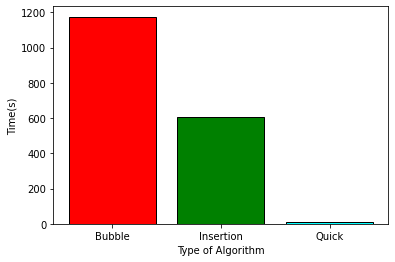

In [ ]:
x_pos = np.arange(len(our_time))

fig, ax = plt.subplots()
# Create bars with different colors
plt.bar(x_pos, our_time, color=['red', 'green', 'cyan'], edgecolor = 'black')
plt.xticks(x_pos, ('Bubble','Insertion', 'Quick'))
ax.set_xlabel('Type of Algorithm')
ax.set_ylabel('Time(s)')
# Show graph
plt.show()

### 4. What is the most optimal algorithm, in your opinion, and why?

As we can see from the upper graph, although the algorithms have the same worse complexity, the query is executed in very different times. 

The algorithm that takes longer is the Bubble Sort, in fact the latter has an average time complexity $O(n^2)$. 

The second algorithm takes almost half time than the previous one to answer the query, but he has an average complexity time $O(n^2)$ too. 

In my opinion, the most optimal algorithm among these three is the "Our_QuickSortreal" because it is true that as the worst case it has complexity $O(n^2)$ , but its average complexity is different. 
#### Explanation
To sort an array of n distinct elements, Quicksort takes $O(n(log(n))$ time in expectation, averaged over all $n!$ permutations of $n$ elements with equal probability. We used the "last element" pivot strategy and its advantage is to obtain as a simplified algorithm. Since the pivot element is guaranteed to be in the right section in this strategy, we do not need to consider it in the comparison and exchange operations. Furthermore, in the final step of partitioning, we can safely swap the first element of the right section with the pivot element to set it to its final position. In practice, this strategy leads to problems with presorted input data. In an array sorted in ascending order, the pivot element would be the largest element in each iteration and this would decrease performance significantly, but in our case we are assuming that the input is not presorted and for this reason, we can do this choice. 

I think that there should be other sorting algorithm that can do better than this, for example we should try to use Merge Sort or Heap Sort that in general have as worse case time complexity $O(n(log(n))$, but we should in any case run them on the query to get a correct answer.



### 5. Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.

In [ ]:
from collections import defaultdict

In [ ]:
def my_map(line):
    """ 
       The map function takes in input a line and compute 
       the average of the grades for each student and return a dictionary
       with an inverted index: the key is the mean of the student
       and the value is the name_surname of the student.
    """
   
    line = line.split()
    name = " ".join(line[0:2])
    grades = list(map(int, line[2:]))
    single_dict = {}
    somma = 0
    for g in grades:
        somma += g
    single_dict[round(somma/len(grades),2)] = name   # we use round because we want only two decimal positions
    
    return single_dict 
    
def shuffle(file_name):
    """
        This function takes in input the file_name,then opens 
        the file and save the content. Moreover, checks the 
        number of students and the number of grades. Finally, 
        the function does the shuffle and sort, it recalls map
        and the output will be a sorted dictionary by key where the
        key is the average of the grades of the student and the value
        is a list that contains all the name_surname that have the same
        mean.
    """
    
    with open(file_name, "r") as file: 
        lines = file.readlines()

    for line in lines[0:1]:
        n,m = map(int,line.split())
        
    if n< 0 or n> 50000 or m < 1 or m > 1000:
        return 'insert a valid input'    
        
    diz = defaultdict(list)
    
    for line in lines[1:]:
        key = list(my_map(line).keys())[0]
        diz[key].append(my_map(line)[key])
    
    return dict(sorted(diz.items(), reverse = True))


def reduce(diz):
    """
    This function will do the action of reduce, in this
    case is needed to sort the values of the dictionary created by shuffle.
    At the end all the lists associated with the keys will be sorted.
    """
    for key in diz:
        diz[key].sort()
    return diz

def query(file_name):
    """
    This is the function that will be used to answer the query.
    It takes in input the file_name and uses the function reduce
    on the output of the function shuffle(that uses map).
    Finilly, the function creates a new file and writes the 
    desired result
    """
    
    result = reduce(shuffle(file_name))
    
    file_out = open("RankingList2.txt","w") #write mode
    
    for grade in result:
        for name_surname in result[grade]:
            file_out.write(name_surname + ' ' + str(grade) + '\n')
        
    file_out.close()
    
    return None
    


#### If you want to try the algorithm and generate the Ranking.txt, uncomment the following cell

In [ ]:
#query(my_input)

In [ ]:
time_start = time.time()
query(my_input)
time_end = time.time()
our_time.append(time_end-time_start)

In [ ]:
our_time

[1175.0958490371704, 604.1571383476257, 11.360676288604736, 23.232707738876343]

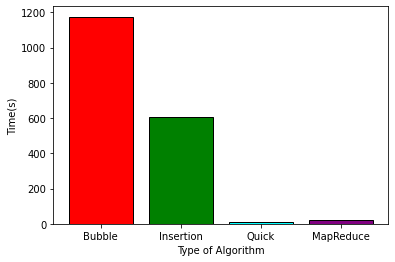

In [ ]:
x_pos = np.arange(len(our_time))

fig, ax = plt.subplots()
# Create bars with different colors
plt.bar(x_pos, our_time, color=['red', 'green', 'cyan','purple'], edgecolor = 'black')
plt.xticks(x_pos, ('Bubble','Insertion', 'Quick', 'MapReduce'))
ax.set_xlabel('Type of Algorithm')
ax.set_ylabel('Time(s)')
# Show graph
plt.show()

We have added to the previous graph the time taken of the algorithm that uses mapreduce. The latter algorithm takes less time than bubble sort and insertion sort but still more than quick sort, just over double.